TIME SERIES ANALYSIS WITH RNN NETWORKS

A recurrent neural network (RNN) is a special type of artificial neural network adapted to work for time series data or data that involves sequences. Even though RNNs are quite powerful, they suffer from Vanishing gradient problem which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: Long Short Term Networks(LSTM) or other some different types of RNN network type Bidirectional LSTM, GRU, CuDNN. 

- RNNs have various advantages, such as:

Ability to handle sequence data

Ability to handle inputs of varying lengths

Ability to store or “memorize” historical information

- The disadvantages are:

The computation can be very slow.

The network does not take into account future inputs to make decisions.

Vanishing gradient problem, where the gradients used to compute the weight update may get very close to zero, preventing the network from learning new weights. The deeper the network, the more pronounced this problem is.

-For timeseries analysis with RNN first of all

1- Normalize data

2- Prepare sliding window function

3- Split the data into train and test set

4-Build the model 

5- Train the model 

6- Calculate and visualize predictions

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.activations import relu, selu, gelu
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.layers import LSTM, GRU, RNN
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import StratifiedKFold

In [ ]:
def download_data():  ### This dude will download the dataset from the directory directly!
  import requests
  url = "https://raw.githubusercontent.com/y-akbal/Some-Usefull-Machine-Learning-Stuff/main/HW/Lecture_Notes/data.csv"
  res = requests.get(url, allow_redirects=True)
  with open('data.csv','wb') as file:
    file.write(res.content)

download_data()     
os.listdir()
os.path.exists("data.csv")

True

In [ ]:
X = pd.read_csv("data.csv").iloc[:, -1]

In [ ]:
X = X[5000:]  ### pandas series

Normalize the data 

In [ ]:
data = (X - X.mean())/X.std()

CHECK STATIONARY OF DATA

In time series analysis, if data is stationary it can be better modelling and give better result. For the purpose of transforming non-stationary data to stationary data, firstly we apply Adulf Fuller test. If p value is greater than 0.005 we can reject null hypothesis that means data is non-stationary. 

In [ ]:
raw_data = pd.read_csv("data.csv").iloc[:, -1]

In [ ]:

from statsmodels.tsa.stattools import adfuller 

adf = adfuller(raw_data)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -22.38600040918741
p-value :  0.0
# n_lags :  52
No of observation:  57163
 critical value 1% : -3.430464402562423
 critical value 5% : -2.861590563722708
 critical value 10% : -2.5667969133729893


As a result of the test, p value is less than 0.005 so data is stationary.  

CHECK AUTOCORELATION 

In [ ]:
import scipy
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

In [ ]:
raw_data = pd.read_csv("data.csv").iloc[:, -1]

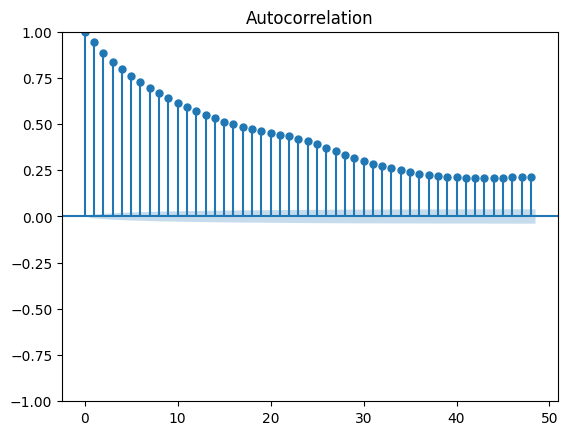

In [ ]:
plot_acf(raw_data);

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


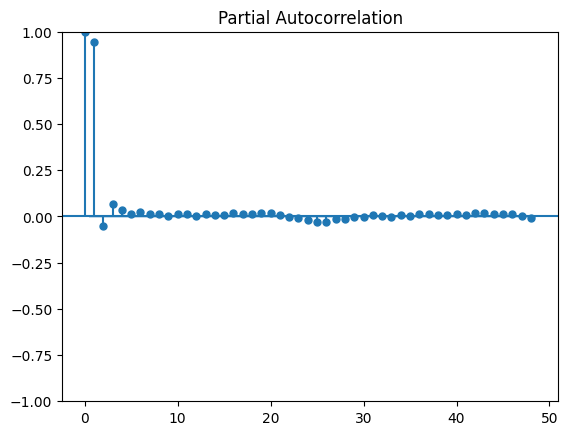

In [ ]:
plot_pacf(raw_data);

#### Create a DataFrame to compare all situations and results of each model

### MODEL-1

CALCULATE SLIDING WINDOW

To make prediction with defining window size is really important. We can do this by using previous time steps as input variables and use the next time step as the output variable.

In [ ]:
window_size=150

def sliding_window(data, window_size = window_size):
  data = np.array(data)
  N = len(data)
  X = []
  y = []
  for i in range(N-1-window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
  return np.array(X), np.array(y)

In [ ]:
X, y = sliding_window(data)

SPLITING DATA

For modelling we must create train and test data but at this time we must consider sliding window.

In [ ]:
alpha = 0.8
N = len(data)
cut_off = int(alpha*N)
X_train, y_train = sliding_window(data[:cut_off])
X_test, y_test = sliding_window(data[cut_off:])

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [ ]:
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

BUILDING LSTM MODEL

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events.

MODEL 2 

After first model, we can try bigger number for layer size for better result

In [ ]:
lstm1_layer_size=list()


In [ ]:
lstm1_r2_scores=list()

In [ ]:
for i in range(150,750,150): 
  lstm1_layer_size.append(i)   
  model = Sequential([LSTM(i),
                       Dense(i,activation='gelu'),
                       Dropout(0.4),
                       Dense(i,activation='gelu'),
                       Dense(1)])
  model.compile(loss='mse',optimizer='adam')
  model.fit(X_train,y_train,batch_size=500,epochs=20,validation_data=(X_test,y_test))
  y_pred = model.predict(X_test)
  y_pred = y_pred.reshape(-1)
  scores=r2_score(y_test, y_pred)
  lstm1_r2_scores.append(scores)

Epoch 1/20
84/84 [==============================] - 6s 40ms/step - loss: 0.2003 - val_loss: 0.1236
Epoch 2/20
84/84 [==============================] - 3s 33ms/step - loss: 0.1213 - val_loss: 0.1175
Epoch 3/20
84/84 [==============================] - 3s 35ms/step - loss: 0.1185 - val_loss: 0.1163
Epoch 4/20
84/84 [==============================] - 3s 33ms/step - loss: 0.1178 - val_loss: 0.1150
Epoch 5/20
84/84 [==============================] - 3s 33ms/step - loss: 0.1171 - val_loss: 0.1149
Epoch 6/20
84/84 [==============================] - 3s 33ms/step - loss: 0.1173 - val_loss: 0.1146
Epoch 7/20
84/84 [==============================] - 3s 32ms/step - loss: 0.1169 - val_loss: 0.1144
Epoch 8/20
84/84 [==============================] - 3s 32ms/step - loss: 0.1168 - val_loss: 0.1141
Epoch 9/20
84/84 [==============================] - 3s 33ms/step - loss: 0.1166 - val_loss: 0.1145
Epoch 10/20
84/84 [==============================] - 3s 35ms/step - loss: 0.1172 - val_loss: 0.1144
Epoch 11/

In [ ]:
lstm1_dict= dict(zip(lstm1_layer_size,lstm1_r2_scores))
print('LSTM with window size:150')
print(lstm1_dict)
  

LSTM with window size:150
{150: 0.8937449759388971, 300: 0.8933588280559653, 450: 0.8899827507950827, 600: 0.8934343743065397}


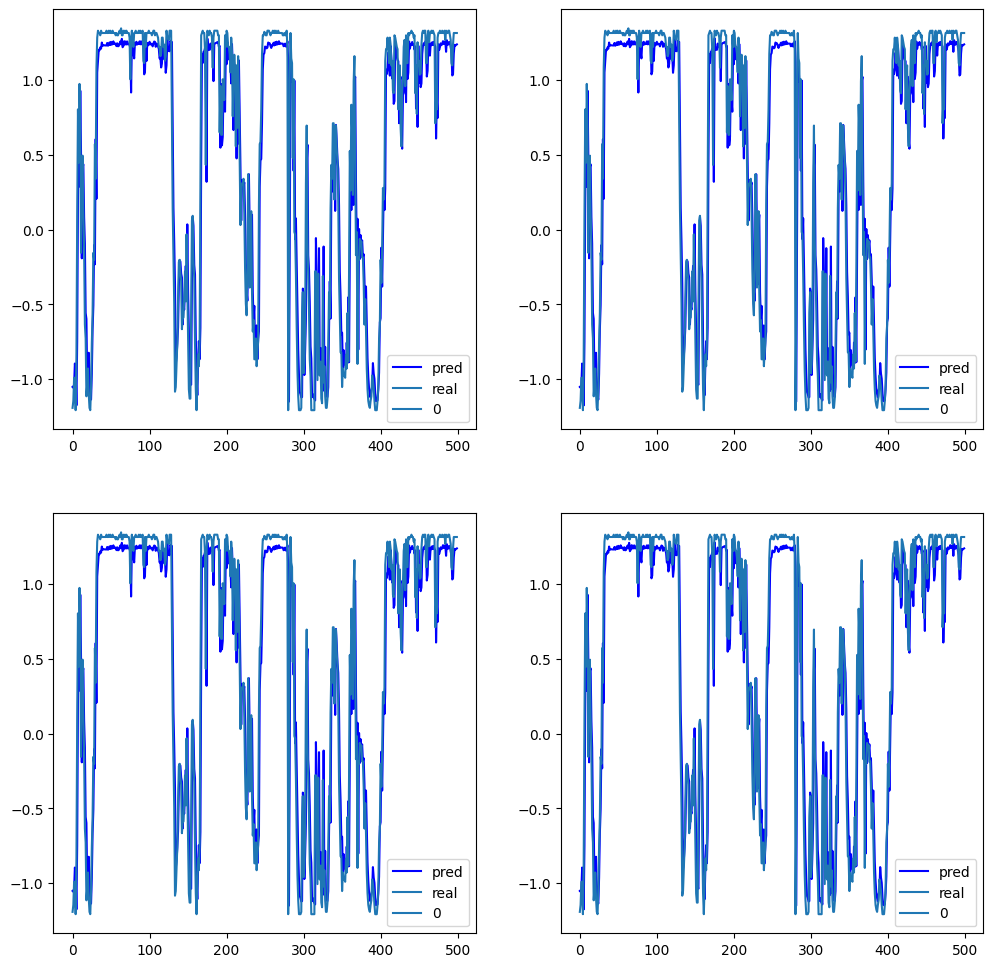

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12,12),dpi=100)
for i in range(len(lstm1_r2_scores)):
  x=i//2
  y= i %2
  sns.lineplot(y_pred[:500], label = "pred",c='blue', ax=ax[x,y])
  sns.lineplot(y_test[:500], label = "real",c='red',ax=ax[x,y])
  ax[x,y].xaxis.label.set_size(15)
  ax[x,y].yaxis.label.set_size(15)
plt.legend()
plt.show()

### model-2 USING GRU 

GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

### GRU model

In [ ]:
gru1_layer_size=list()
gru1_r2_scores=list()

In [ ]:
for i in range(150,750,150): 
  gru1_layer_size.append(i)   
  model = Sequential([GRU(i),
                       Dense(i,activation='gelu'),
                       Dropout(0.4),
                       Dense(i,activation='gelu'),
                       Dropout(0.4),
                       Dense(1)])
  model.compile(loss='mse',optimizer='adam')
  model.fit(X_train,y_train,batch_size=500,epochs=20,validation_data=(X_test,y_test))
  y_pred = model.predict(X_test)
  y_pred = y_pred.reshape(-1)
  scores=r2_score(y_test, y_pred)
  gru1_r2_scores.append(scores)


Epoch 1/20
84/84 [==============================] - 8s 46ms/step - loss: 0.2033 - val_loss: 0.1178
Epoch 2/20
84/84 [==============================] - 3s 36ms/step - loss: 0.1264 - val_loss: 0.1166
Epoch 3/20
84/84 [==============================] - 3s 37ms/step - loss: 0.1231 - val_loss: 0.1146
Epoch 4/20
84/84 [==============================] - 3s 37ms/step - loss: 0.1227 - val_loss: 0.1150
Epoch 5/20
84/84 [==============================] - 3s 37ms/step - loss: 0.1222 - val_loss: 0.1150
Epoch 6/20
84/84 [==============================] - 3s 37ms/step - loss: 0.1215 - val_loss: 0.1169
Epoch 7/20
84/84 [==============================] - 3s 38ms/step - loss: 0.1216 - val_loss: 0.1154
Epoch 8/20
84/84 [==============================] - 3s 38ms/step - loss: 0.1218 - val_loss: 0.1167
Epoch 9/20
84/84 [==============================] - 3s 37ms/step - loss: 0.1216 - val_loss: 0.1141
Epoch 10/20
84/84 [==============================] - 3s 37ms/step - loss: 0.1214 - val_loss: 0.1145
Epoch 11/

In [ ]:
gru1_dict= dict(zip(gru1_layer_size,gru1_r2_scores))
print('GRU with window size: 150')
print(gru1_dict)
  

GRU with window size: 150
{150: 0.8932181457508649, 300: 0.8896718376393074, 450: 0.8921276251407507, 600: 0.8902704196396167}


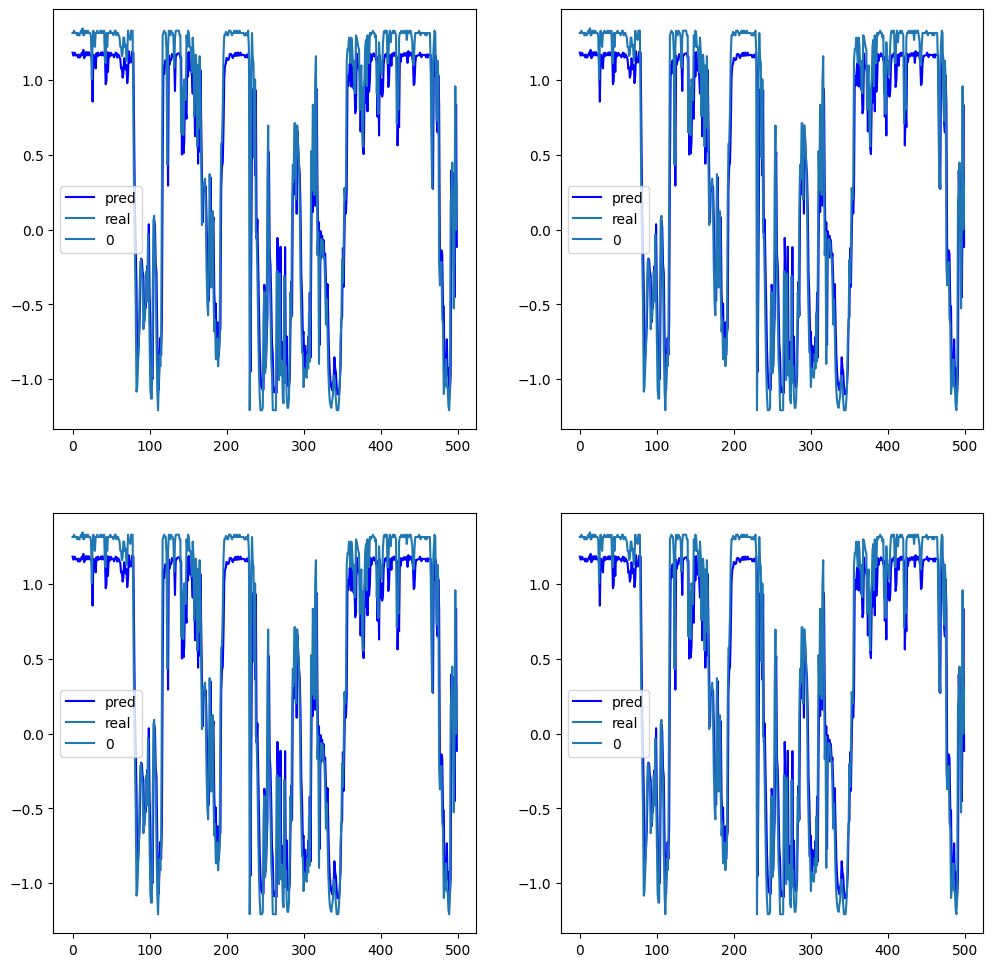

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12,12),dpi=100)
for i in range(len(gru1_r2_scores)):
  x=i//2
  y= i %2
  sns.lineplot(y_pred[:500], label = "pred",c='blue', ax=ax[x,y])
  sns.lineplot(y_test[:500], label = "real",c='black',ax=ax[x,y])
  ax[x,y].xaxis.label.set_size(15)
  ax[x,y].yaxis.label.set_size(15)
plt.legend()
plt.show()

### LSTM MODEL-2
Now I will use different window function and Min Max Scaling and see how chanege LSTM and GRU model score

In [ ]:
df = pd.read_csv("data.csv").iloc[:, -1]

### Using different type of Normalization

In [ ]:
df_scaled = (X - X.min())/(X.max()-X.min())  - 1/2 

### Changing lag size

In [ ]:
def sliding_window(data, window_size = 400):
  data = np.array(data)
  N = len(data)
  X = []
  y = []
  for i in range(N-1-window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
  return np.array(X), np.array(y)

### Splitting the data

In [ ]:
alpha = 0.8
N = len(data)
cut_off = int(alpha*N)
X_train, y_train = sliding_window(data[:cut_off])
X_test, y_test = sliding_window(data[cut_off:])

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [ ]:
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

### LSTM-2 MODEL

In [ ]:
lstm2_layer_size=[]
lstm2_r2_scores=[]

In [ ]:

for i in range(32,160,32):  
  lstm2_layer_size.append(i)  
  model = Sequential([LSTM(i),
                      Dense(i,activation='gelu'),
                      Dropout(0.4),
                      Dense(i,activation='gelu'),
                      Dense(1)])
  model.compile(loss='mse',optimizer='adam')
  model.fit(X_train,y_train,batch_size=500,epochs=20,validation_data=(X_test,y_test))
  y_pred = model.predict(X_test)
  y_pred = y_pred.reshape(-1)
  scores=r2_score(y_test, y_pred)
  lstm2_r2_scores.append(scores)


Epoch 1/20
83/83 [==============================] - 5s 26ms/step - loss: 0.4134 - val_loss: 0.1861
Epoch 2/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1806 - val_loss: 0.1351
Epoch 3/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1426 - val_loss: 0.1180
Epoch 4/20
83/83 [==============================] - 2s 24ms/step - loss: 0.1322 - val_loss: 0.1187
Epoch 5/20
83/83 [==============================] - 2s 20ms/step - loss: 0.1314 - val_loss: 0.1175
Epoch 6/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1304 - val_loss: 0.1194
Epoch 7/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1286 - val_loss: 0.1180
Epoch 8/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1278 - val_loss: 0.1171
Epoch 9/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1260 - val_loss: 0.1215
Epoch 10/20
83/83 [==============================] - 2s 19ms/step - loss: 0.1245 - val_loss: 0.1189
Epoch 11/

In [ ]:
lstm2_dict= dict(zip(lstm2_layer_size,lstm2_r2_scores))
print('LSTM with window size:400')
print(lstm2_dict)

LSTM with window size:400
{32: 0.8588582300308725, 64: 0.8912024315225875, 96: 0.8924675211647604, 128: 0.8918568328954177}


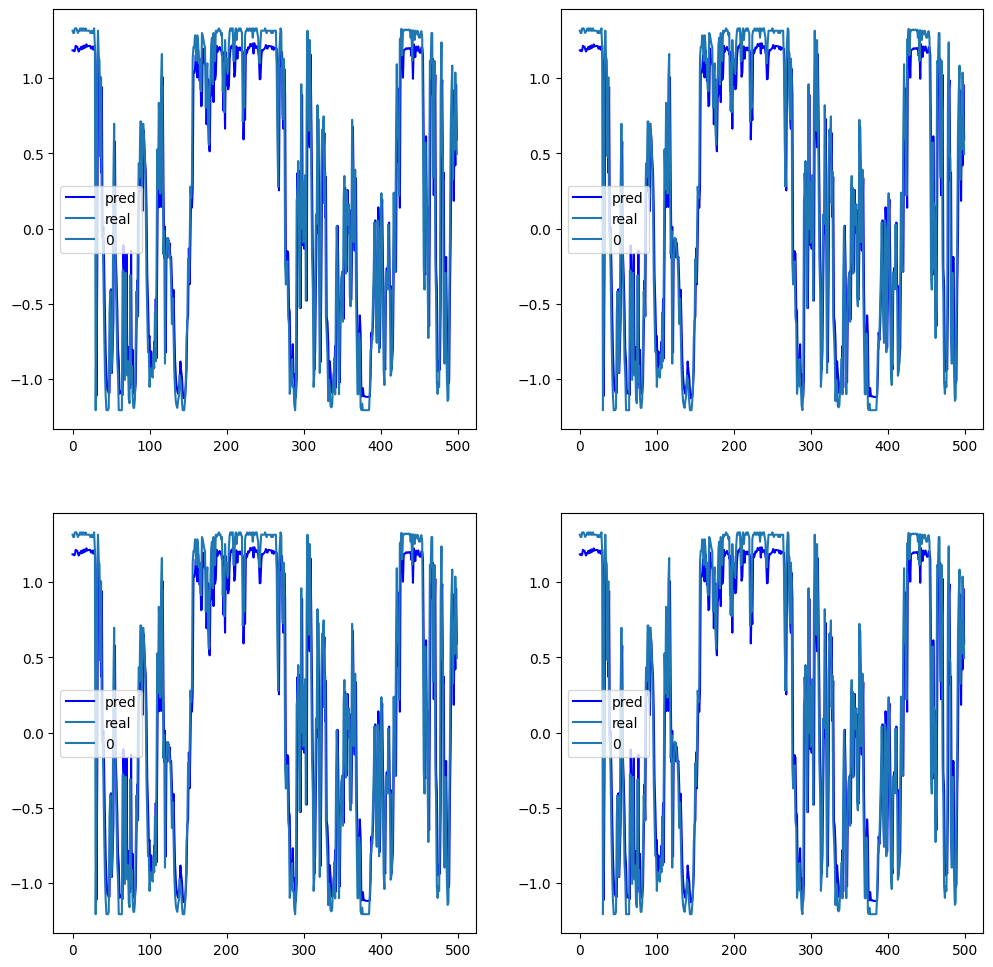

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12,12),dpi=100)
for i in range(len(lstm2_r2_scores)):
  x=i//2
  y= i %2
  sns.lineplot(y_pred[:500], label = "pred",c='blue', ax=ax[x,y])
  sns.lineplot(y_test[:500], label = "real",c='red',ax=ax[x,y])
  ax[x,y].xaxis.label.set_size(15)
  ax[x,y].yaxis.label.set_size(15)
plt.legend()
plt.show()

GRU MODEL-2

In [ ]:
gru2_layer_size=[]
gru2_r2_scores=[]

In [ ]:
for i in range(32,160,32):  
  gru2_layer_size.append(i)  
  model = Sequential([GRU(i),
                       Dense(5*i,activation='gelu'),
                       Dropout(0.4),
                       Dense(5*i,activation='gelu'),
                       Dropout(0.4),
                       Dense(1)])
  model.compile(loss='mse',optimizer='adam')
  model.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_test,y_test))
  y_pred = model.predict(X_test)
  y_pred = y_pred.reshape(-1)
  scores=r2_score(y_test, y_pred)
  gru2_r2_scores.append(scores)

Epoch 1/20
647/647 [==============================] - 18s 17ms/step - loss: 0.1371 - val_loss: 0.1214
Epoch 2/20
647/647 [==============================] - 10s 15ms/step - loss: 0.1220 - val_loss: 0.1175
Epoch 3/20
647/647 [==============================] - 11s 16ms/step - loss: 0.1218 - val_loss: 0.1152
Epoch 4/20
647/647 [==============================] - 10s 16ms/step - loss: 0.1211 - val_loss: 0.1189
Epoch 5/20
647/647 [==============================] - 10s 16ms/step - loss: 0.1208 - val_loss: 0.1151
Epoch 6/20
647/647 [==============================] - 11s 16ms/step - loss: 0.1206 - val_loss: 0.1151
Epoch 7/20
647/647 [==============================] - 10s 16ms/step - loss: 0.1204 - val_loss: 0.1207
Epoch 8/20
647/647 [==============================] - 10s 15ms/step - loss: 0.1203 - val_loss: 0.1143
Epoch 9/20
647/647 [==============================] - 12s 18ms/step - loss: 0.1194 - val_loss: 0.1160
Epoch 10/20
647/647 [==============================] - 10s 16ms/step - loss: 0.119

In [ ]:
gru2_dict= dict(zip(gru2_layer_size,gru2_r2_scores))
print('GRU with window size:400')
print(gru2_dict)

GRU with window size:400
{32: 0.8922421524956, 64: 0.8922539742873972, 96: 0.8933906258994456, 128: 0.8889324943452543}


IndexError: ignored

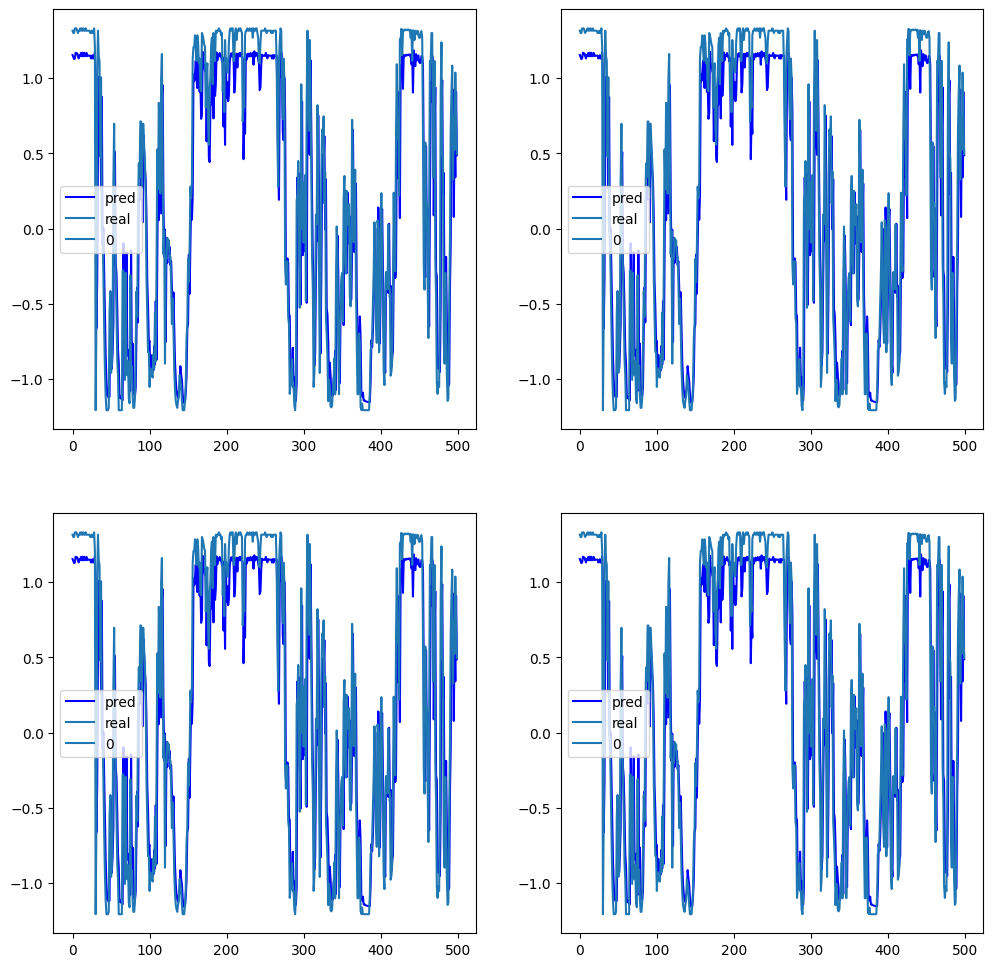

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12,12),dpi=100)
for i in range(len(gru2_r2_scores)):
  x=i//2
  y= i %2
  sns.lineplot(y_pred[:500], label = "pred",c='blue', ax=ax[x,y])
  sns.lineplot(y_test[:500], label = "real",c='red',ax=ax[x,y])
  ax[x,y].xaxis.label.set_size(15)
  ax[x,y].yaxis.label.set_size(15)
plt.legend()
plt.show()

### TOTAL RESULT OF ALL MODEL

In [ ]:
lstm_dict= {}
lstm_dict.update(lstm1_dict)
lstm_dict.update(lstm2_dict)
lstm_dict

{150: 0.8937449759388971,
 300: 0.8933588280559653,
 450: 0.8899827507950827,
 600: 0.8934343743065397,
 32: 0.8588582300308725,
 64: 0.8912024315225875,
 96: 0.8924675211647604,
 128: 0.8918568328954177}

In [ ]:
lstm_df = pd.DataFrame(lstm_dict.items(), columns=['Neuron of LSTM', 'R2 score of LSTM'])
lstm_df

,Neuron of LSTM,R2 score of LSTM
0,150,0.893745
1,300,0.893359
2,450,0.889983
3,600,0.893434
4,32,0.858858
5,64,0.891202
6,96,0.892468
7,128,0.891857


In [ ]:
gru_dict= {}
gru_dict.update(gru1_dict)
gru_dict.update(gru2_dict)
gru_dict

{150: 0.8932181457508649,
 300: 0.8896718376393074,
 450: 0.8921276251407507,
 600: 0.8902704196396167,
 32: 0.8922421524956,
 64: 0.8922539742873972,
 96: 0.8933906258994456,
 128: 0.8889324943452543}

In [ ]:
gru_df = pd.DataFrame(gru_dict.items(), columns=['Neuron of GRU', 'R2 score of GRU'])
gru_df



,Neuron of GRU,R2 score of GRU
0,150,0.893218
1,300,0.889672
2,450,0.892128
3,600,0.890270
4,32,0.892242
5,64,0.892254
6,96,0.893391
7,128,0.888932


In [ ]:
gru_df.to_excel('gru-scores.xlsx', sheet_name = 'New_sheet')

In [ ]:
lstm_df.to_excel('lstm-scores.xlsx', sheet_name = 'New_sheet')

In [ ]:
from google.colab import files

files.download('lstm-scores.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('gru-scores.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>